<a href="https://colab.research.google.com/github/EmmanuelChingozho/Chingozho_IT533/blob/main/Copy_of_Copy_of_Module9_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Module 9: Random Forest Classification**

In this notebook, we are going to set up a Random Forest model in Python. At the end of this module, you will be able to:

* Explain what Random Forest does
* Build and evaluate a Random Forest

**Be sure to expand all the hidden cells, run all the code, and do all the exercises--you will need the techniques for the lesson lab!**




#**What is Random Forest?**
For the previous module on simple tree construction, there's a chance that each of you have slightly different numeric results. Why? Because the sampling to produce the training and test sets is random. So, while performing the train_test_split, each student built the model based on a somewhat different training set. This means that each student's model is also slightly different from that of her peers. 

So, whose results are the actual, real results, then?

The answer is: We really can't tell. Each tree that each student built has some validity, and we can have some confidence in its final predictions. 

But wouldn't it be great if we could have more confidence and come to a better overall result for the entire class? That's what the popular Random Forest algorithm does.

Random Forest doesn't build just one tree--it builds an entire classroom full of trees, each one of which is based on a slightly different training set (which is, in fact, a small randomized subset of the big overall training set). To save processing power, Random Forest then picks just a random few of the attributes to consider when building each tree, so that no two trees are based on the same attributes. Finally, Random Forest evaluates all the trees it has constructed and, for a given prediction, outputs the class assignment that is the mode of the classes (classification) or, if you run it as a regression tree, the mean prediction (regression) of the individual trees.

<div>
<img src="https://raw.githubusercontent.com/shstreuber/Data-Mining/master/images/randomforest2.png" width="600">
</div>

So, we have:
* A number of trees
* Using a random subset of features in the dataset to make their split decisions
* Built on a number of slightly different training subsets, selected as random samples with replacement (= bootstrap aggregating or bagging) from the overall training set
* A voting function that selects the mode of the classes (classification or the mean prediction (regression)

In other words, we introduce dual randomness into our classification in order to pick the best model from the places where all the individual trees overlap. That leaves us with much greater accuracy for our model.

We are working with the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from the scikit-learn package.


#**0. Preparation and Setup**
As before, we are following the basic classification steps:

1. Exploratory Data Analysis to see how the data is distributed and to determine what the class attribute in the dataset should be. This will be the attribute you'll predict later on
2. Preprocess the data (remove n/a, transform data types as needed, deal with missing data) and ensure that the dependent attribute is CATEGORICAL
3. Split the data into a training set and a test set
4. Build the model based on the training set
5. Test the model on the test set 
6. Determine the quality of the model with the help of a Confusion Matrix and a Classification Report.

As with our previous problems, we will use the insurance dataset again.

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import spatial
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

from IPython.display import HTML # This is just for me so I can embed videos
from IPython.display import Image # This is just for me so I can embed images

#Reading in the data as insurance dataframe
insurance = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/insurance_with_categories.csv")

#Verifying that we can see the data
insurance.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#**1. Exploratory Data Analysis (EDA)**
As before, we have the option to either do this in a code cell, or to import the HTML-based pandas_profile package. 

Test your EDA skills below:

In [ ]:
insurance.describe(include = 'all'), print("***DATA OVERVIEW***")# Build a data summary for ALL data in the set (not just numeric!)

***DATA OVERVIEW***


(                age   sex          bmi  ...  smoker     region       charges
 count   1338.000000  1338  1338.000000  ...    1338       1338   1338.000000
 unique          NaN     2          NaN  ...       2          4           NaN
 top             NaN  male          NaN  ...      no  southeast           NaN
 freq            NaN   676          NaN  ...    1064        364           NaN
 mean      39.207025   NaN    30.663397  ...     NaN        NaN  13270.422265
 std       14.049960   NaN     6.098187  ...     NaN        NaN  12110.011237
 min       18.000000   NaN    15.960000  ...     NaN        NaN   1121.873900
 25%       27.000000   NaN    26.296250  ...     NaN        NaN   4740.287150
 50%       39.000000   NaN    30.400000  ...     NaN        NaN   9382.033000
 75%       51.000000   NaN    34.693750  ...     NaN        NaN  16639.912515
 max       64.000000   NaN    53.130000  ...     NaN        NaN  63770.428010
 
 [11 rows x 7 columns], None)

In [ ]:
insurance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [ ]:
insurance.corr(), print("***DATA CORRELATIONS")

***DATA CORRELATIONS


(               age       bmi  children   charges
 age       1.000000  0.109272  0.042469  0.299008
 bmi       0.109272  1.000000  0.012759  0.198341
 children  0.042469  0.012759  1.000000  0.067998
 charges   0.299008  0.198341  0.067998  1.000000, None)

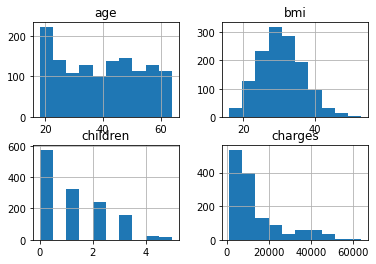

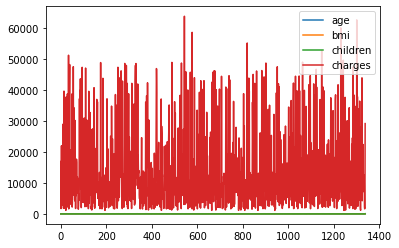

In [ ]:
# Build a histogram for the numeric values
insurance.hist()
insurance.plot()

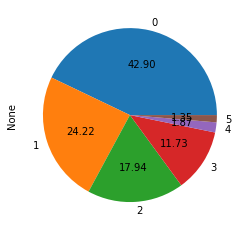

In [ ]:
insurance.groupby('children').size().plot(kind='pie', autopct='%.2f')


#**2. Preprocessing: Building the Analysis Set**
You have done this before. Build an insurance_rf dataset consisting of age, bmi, children, charges, and--again--region as the class attribute.

In [ ]:
insurance_rf = pd.DataFrame(insurance, columns = ['age', 'bmi', 'children','charges','region'])
insurance_rf.head()

,age,bmi,children,charges,region
0,19,27.900,0,16884.92400,southwest
1,18,33.770,1,1725.55230,southeast
2,28,33.000,3,4449.46200,southeast
3,33,22.705,0,21984.47061,northwest
4,32,28.880,0,3866.85520,northwest


# **3. Building the Training and Test Datasets**
As before, we cannot do classification without training and test data. You did this previously. Do it again--we want 20% of the data set as test and 80% as training set.

In [ ]:
insurance_rf.children.unique()

array([0, 1, 3, 2, 5, 4])

In [ ]:
from sklearn.model_selection import train_test_split
x=insurance_rf.iloc[:,:4] # all parameters
y=insurance_rf['region'] # class labels 'southwest', 'southeast', 'northwest', 'northeast'
X_train, X_test, y_train, y_test =  train_test_split(x,y, random_state=0)                            # COMPLETE THIS LINE!
print("X_train shape: {}".format(X_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1003, 4)
y_test shape: (335,)


# **4. Building and Training the Classifier**
We are going to use the [RandomForestClassifier from sklearn.ensemble](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). The RandomForestClassifier has a number of really interesting parameters that we can control in order to optimize our model to run quickly and efficiently, especially the sub-sample size, which is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

##**4.1 Building the Classifier**

The most important parameters are:
* n_estimators int, default=100 --
The number of trees in the forest.
* criterion{“gini”, “entropy”}, default=”gini” -- 
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
* max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto” -- 
The number of features to consider when looking for the best split: If int, then consider max_features features at each split. If “auto”, then max_features=sqrt(n_features). If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.
* max_depthint, default=None -- 
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* min_samples_split int or float, default=2
The minimum number of samples required to split an internal node
* bootstrap bool, default=True -- Whether bootstrap samples are used when building trees (which is 50% of the whole idea behind Random Forest). If False, the whole dataset is used to build each tree.

Let's get started!

In [ ]:
# Configuring the classifier and using get_params to double-check all the parameters with which it is configured

rf = RandomForestClassifier()
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [ ]:
from sklearn.model_selection import train_test_split
x=insurance_rf.iloc[:,:4] # all parameters
y=insurance_rf['region'] # class labels 'southwest', 'southeast', 'northwest', 'northeast'
X_train, X_test, y_train, y_test =  train_test_split(x,y, random_state=0)                            # COMPLETE THIS LINE!
print("X_train shape: {}".format(X_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1003, 4)
y_test shape: (335,)


In [ ]:
rf =RandomForestClassifier(criterion='entropy')

##**4.2 Training the Classifier**
Just like before, we are using .fit() to train our classifier! Remember that we named it rf. You'll want your training data inside the parentheses.

Give it a shot below!

In [ ]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Just incase you're lost: The solutions are posted at the end of this workbook.

# **5. Use the Classifier to test and predict**
There is nothing different about the steps below than what you have already done. Uncomment the second line starting with "print" if you would like to see the output of your predictions.

In [ ]:
y_pred = rf.predict(X_test)
# print(y_pred) # If you want to see the big long list, uncomment this line!

# **6. Evaluate the Quality of the Model**
Again, we will look at the following:
1. Accuracy score
2. Confusion matrix
3. Classification Report

The interesting part will be to see if any of the predictions have improved from the simple tree model in the previous module.

In [ ]:
# First, the accuracy score
accuracy_score(y_test, y_pred)

0.33134328358208953

What was the accuracy score for the simple tree? Did using Random Forest improve it? Record your observations below.

Improved a little bit from 31% to 33%

1075    southeast
131     northeast
15      southwest
1223    southeast
1137    northwest
Name: region, dtype: object

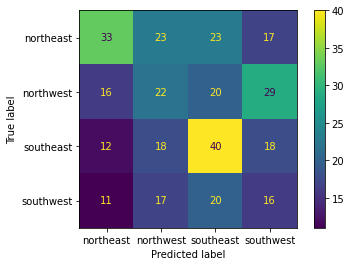

In [ ]:
# Next, the Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test)
y_train.head()

What did the Confusion Matrix look like for the simple tree? What differences do you notice? Record your observations in the field below.

The prediction is almost the same no signiificant change.

In [ ]:
# Finally, the Classification Report
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

print(metrics.classification_report(y_test, y_pred, labels=['southwest', 'southeast', 'northwest', 'northeast']))

              precision    recall  f1-score   support

   southwest       0.20      0.25      0.22        64
   southeast       0.39      0.45      0.42        88
   northwest       0.28      0.25      0.26        87
   northeast       0.46      0.34      0.39        96

    accuracy                           0.33       335
   macro avg       0.33      0.33      0.32       335
weighted avg       0.34      0.33      0.33       335



Again, compare this output with the output for the simple tree. What are the differences? Overall, would you say that Random Forest works better? Or, given that we're doing a whole lot more processing, is any improvement worth it? Record your answer below.

# **What If ...**
So far, we have used only the default settings on the Random Forest algorithm. What if we play with different configuration settings, such as the number of trees? Or the depth of the trees? Or the minimum samples required to split?

First, let's set up the parameters as variables so that we can easily change them:

In [ ]:
# We are setting up the n_estimators and other configuration parameters so that we can easily change them
# Feel free to comment any of these out or change the values and re-run the cells below to see how this changes the result
n_estimators = 10000 # This is the number of different trees to build; default was 100; we are increasing this number tenfold.
min_samples_split = 5 # Previously, we ran this with the default split of 2
criterion='entropy' # This is for Information Gain; previously, we ran this with the Gini Index

Then, let's build the classifier again, now with the different settings.

In [ ]:
rf2 = RandomForestClassifier(verbose=1, n_estimators=n_estimators, min_samples_split=min_samples_split, criterion=criterion)
rf2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   40.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)

Time to predict and evaluate with accuracy score, Confusion Matrix, and Classification Report!

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.33432835820895523


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    1.5s finished


              precision    recall  f1-score   support

   southwest       0.20      0.25      0.22        64
   southeast       0.38      0.48      0.42        88
   northwest       0.28      0.22      0.24        87
   northeast       0.47      0.36      0.41        96

    accuracy                           0.33       335
   macro avg       0.33      0.33      0.32       335
weighted avg       0.34      0.33      0.33       335



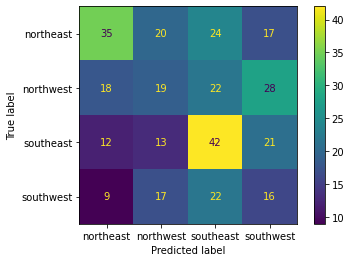

In [ ]:
# Testing and predicting
y_pred = rf2.predict(X_test)

print(accuracy_score(y_test, y_pred))
plot_confusion_matrix(rf2, X_test, y_test)
print(metrics.classification_report(y_test, y_pred, labels=['southwest', 'southeast', 'northwest', 'northeast']))

##Your Turn
Try this with a number of different settings. Does using 1,000 trees improve the accuracy by a little--or a lot? What about 10,000 trees? 

Play around with the settings, then record below what you have done and what your results were. Interpret what you're seeing: Is more processing worth it? Or is there a point where we accept the results as "good enough"?

#**Towards Optimization**
You just played with the tree setting manually. What if we could cycle the algorithm through a list of "number of trees" settings and see what happens then?

All we need is a quick "for" loop with a range. This range setting is configured like this:


```
range(starting_point, termination_point, increment_size)
```
In other words range(20,200,20) means that we start with 20 trees and go up to 200 in steps of 20. So, we will look at the behavior for 20, 40, 60, 80, 100, 120, 140, 160, 180, and 200 trees. The code is below.




In [ ]:
# We can even cycle through a number of trees in the Random Forest
for n_estimators in range(20,200,20):
    print('Accuracy score using n_estimators =', n_estimators, end = ': ')
         
    rf3 = RandomForestClassifier(n_estimators = n_estimators, verbose=1)
    rf3.fit(X_train, y_train)
    y_pred = rf3.predict(X_test)
    print(accuracy_score(y_test, y_pred))

Accuracy score using n_estimators = 20: 0.3492537313432836
Accuracy score using n_estimators = 40: 0.34626865671641793
Accuracy score using n_estimators = 60: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


0.33432835820895523
Accuracy score using n_estimators = 80: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.33134328358208953
Accuracy score using n_estimators = 100: 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.3492537313432836
Accuracy score using n_estimators = 120: 

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.33432835820895523
Accuracy score using n_estimators = 140: 

[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.3402985074626866
Accuracy score using n_estimators = 160: 

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.3164179104477612
Accuracy score using n_estimators = 180: 0.34328358208955223


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


How about setting this to 1,000 or even 10,000 trees and seeing the accuracy score change? Go ahead and play with the range setting! Then record below which range setting you think works best for you.

Accuracy scores of 10000 trees has changed but not with a large margin.

#Solutions (to help you if you get stuck)

In [ ]:
# This is the solution for task 2 above. 
insurance_rf = pd.DataFrame(insurance, columns = ['age', 'bmi', 'children','charges','region'])
insurance_rf.head()

,age,bmi,children,charges,region
0,19,27.900,0,16884.92400,southwest
1,18,33.770,1,1725.55230,southeast
2,28,33.000,3,4449.46200,southeast
3,33,22.705,0,21984.47061,northwest
4,32,28.880,0,3866.85520,northwest


In [ ]:
# This is the solution for task 3 above:
from sklearn.model_selection import train_test_split
x=insurance_rf.iloc[:,:4] # all parameters
y=insurance_rf['region'] # class labels 'southwest', 'southeast', 'northwest', 'northeast'
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2) 
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (1070, 4)
X_test shape: (268, 4)


In [ ]:
# Solution for task 4.2
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)